In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define file path and parameters
fileFullPath = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\metal_plate_distance_3m\master_0000_data.bin'
frameIdx = 50  # Index of the frame to read
numSamplePerChirp = 256  # Number of samples per chirp
numChirpPerLoop = 12  # Number of chirps per loop
numLoops = 64  # Number of loops per frame
numRXPerDevice = 4  # Number of receiving channels per device
numDevices = 4  # Number of devices in the cascade (if needed)

# Function to read binary radar data
def readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice):
    Expected_Num_SamplesPerFrame = numSamplePerChirp * numChirpPerLoop * numLoops * numRXPerDevice * 2
    with open(fileFullPath, 'rb') as fp:
        # Move to the desired frame in the file
        fp.seek((frameIdx - 1) * Expected_Num_SamplesPerFrame * 2)
        adcData1 = np.fromfile(fp, dtype=np.uint16, count=Expected_Num_SamplesPerFrame)

    # Convert the 16-bit data to signed integers
    neg = (adcData1 >> 15) == 1  # Check the sign bit
    adcData1 = adcData1.astype(np.int32)
    adcData1[neg] -= 2**16

    # Combine the I and Q channels into complex values
    adcData1 = adcData1[0::2] + 1j * adcData1[1::2]

    # Reshape and permute the data
    adcData1Complex = np.reshape(adcData1, (numRXPerDevice, numSamplePerChirp, numChirpPerLoop, numLoops), order='F')
    adcData1Complex = np.transpose(adcData1Complex, (1, 3, 0, 2))  # Permute dimensions
    return adcData1Complex

# Read radar data
adcDataComplex = readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice)

# Select antenna index and extract chirp ADC matrix
antennaIdx = 0  # Indexing starts from 0 in Python
chirp_ADC_matrix = adcDataComplex[:, :, antennaIdx, :]

# Display some results
print(adcDataComplex[1, 0, 0, 0])  # Display sample value
print("Size of chirp_ADC_matrix:", chirp_ADC_matrix.shape)

# Extract first chirp of the first loop
first_chirp_first_loop = chirp_ADC_matrix[:, 0, 0]
all_chirps=chirp_ADC_matrix[:,:,:]
print("Size of the all chirps matrix",all_chirps.shape)
print("Size of first_chirp_first_loop:", first_chirp_first_loop.shape[0])
print(first_chirp_first_loop)

(-242+126j)
Size of chirp_ADC_matrix: (256, 64, 12)
Size of the all chirps matrix (256, 64, 12)
Size of first_chirp_first_loop: 256
[ -41.+339.j -242.+126.j -402.+127.j -136.-249.j -242. -55.j   23.-129.j
  -75.-109.j  105.-111.j  150.+232.j -287.+200.j -310.+330.j -629.-296.j
 -163.-228.j  160.-579.j  176.+122.j   81.+134.j -273.+288.j -465. -54.j
 -271.-250.j -279.-441.j  149.-268.j  -88.-305.j  285.+183.j   55. +13.j
 -279.+282.j -303.-129.j -422.-328.j -146.-330.j   24.-475.j   44.-142.j
  223.-202.j -141. -56.j  101. +55.j -103.-143.j -172.-121.j -118.-247.j
 -158.-366.j  211.-206.j   21.-339.j   57.+227.j  -84.-110.j -375.-217.j
   -1.-494.j  230.-433.j  297. -90.j  173.  +4.j -361. -45.j   62.-196.j
  -96.-471.j  200.-104.j   88.-215.j   81.-147.j  211.-256.j  181.-100.j
   65.+256.j -127.-242.j -365.-264.j  211.-579.j  298.-359.j  501.  -3.j
   88.+103.j  -82. +13.j   60.-218.j   12.-323.j  189.+102.j   23.-358.j
  -85.-288.j  450.-592.j  578. -25.j  498.+350.j -208.+401.j -506

[[ -41.+339.j  -57.+347.j  -41.+329.j ... -108.+455.j -106.+443.j
   -88.+443.j]
 [-242.+126.j -240.+113.j -244.+129.j ... -305.+183.j -306.+195.j
  -287.+195.j]
 [-402.+127.j -386.+109.j -368.+105.j ... -504.+132.j -513.+131.j
  -515.+120.j]
 ...
 [-228. +29.j -222. +34.j -218. +40.j ... -240. +35.j -239. +35.j
  -213. +20.j]
 [ -62.+125.j  -59.+117.j  -69.+126.j ...  -96.+112.j  -79.+111.j
   -89.+100.j]
 [-137.+272.j -146.+293.j -144.+261.j ... -166.+242.j -167.+247.j
  -176.+256.j]]


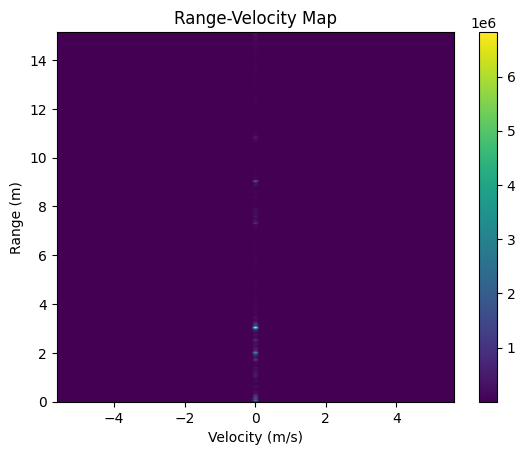

In [17]:
# Reshape the complex array into a matrix of shape (256, 768)
chirps_matrix = np.reshape(all_chirps, (256, 768))

# Output the reshaped matrix
print(chirps_matrix)
# Constants (adjust based on your radar parameters)
fc = 77e9  # Radar operating frequency (77 GHz for mmWave radar)
c = 3e8  # Speed of light (m/s)
sweepBandwidth = 3.16e9  # Bandwidth of the FMCW radar sweep (3.16 GHz)
chirpDuration = 40e-6  # Chirp duration (40 microseconds)

Nfft_range = 320  # Number of FFT points for range dimension
Nfft_doppler = 97# Number of FFT points for Doppler dimension

# Perform 2D FFT along both the range (ADC samples) and Doppler (chirps) dimensions
range_fft = np.fft.fft(chirps_matrix, Nfft_range, axis=0)  # FFT across range (ADC samples)
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, Nfft_doppler, axis=1), axes=1)  # FFT across Doppler (chirps), with shift

# Calculate the range and velocity axis values
range_res = c / (2 * sweepBandwidth)  # Range resolution (meters)
max_range = range_res * (Nfft_range - 1)  # Maximum measurable range
range_axis = np.linspace(0, max_range, Nfft_range)  # Range axis for plotting

doppler_res = 1 / (numChirpPerLoop * chirpDuration*35)  # Doppler resolution (Hz)
max_doppler = doppler_res * (Nfft_doppler / 2)  # Maximum Doppler shift (Hz)

# Doppler axis for plotting (ensure symmetry around 0)
doppler_axis = np.linspace(-max_doppler, max_doppler, Nfft_doppler)

# Convert Doppler frequency to velocity (m/s)
velocity_axis = doppler_axis * (c / (2 * fc))  # Velocity axis using Doppler shift

# Plot the Range-Velocity map (absolute value of FFT)
plt.figure()
plt.imshow((np.abs(doppler_fft)), aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], origin='lower')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Range (m)')
plt.title('Range-Velocity Map')
plt.colorbar()